## Week 3: Tutorial

## Goal: Investigate archaic ancestry in humans from 1000 Genomes data

### Set your individual

In [34]:
# REPLACE with your individual
my_individual = 'HG01149'

## Installing requirements

### Connect to Github and load the necessary data and tools

In [38]:
# %%capture
!export LD_LIBARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!apt install libgsl-dev
!ln -s /usr/lib/x86_64-linux-gnu/libgsl.so /usr/lib/x86_64-linux-gnu/libgsl.so.0
!git clone https://github.com/CCB293/Fall-2021 
!chmod +x Fall-2021/bin/smartpca
!chmod +x Fall-2021/bin/admixture
!cd Fall-2021/data/1000G_archaic/ && unzip 1000G_archaic.geno.zip
# !cd CCB293-testing/data/1000G_archaic && git clone https://github.com/LauritsSkov/Introgression-detection.git

Cloning into 'CCB293-testing'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 187 (delta 84), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (187/187), 22.33 MiB | 6.57 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
# SKIP
#%%capture
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/accessible_genome_masks/StrictMask/20140520.chr17.strict_mask.fasta.gz -O 20140520.chr17.strict_mask.fasta.gz
#!wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/chromFaMasked.tar.gz
#!tar xzvf chromFaMasked.tar.gz
#!wget http://web.corral.tacc.utexas.edu/WGSAdownload/resources/human_ancestor_GRCh37_e71/homo_sapiens_ancestor_17.fa.gz
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
#!apt install autoconf autogen
#!git clone https://github.com/vcftools/vcftools.git
#!cd vcftools && ./autogen.sh && ./configure && make && make install
#!git clone https://github.com/samtools/htslib.git
#!cd htslib && autoheader && autoconf && ./configure && make && make install
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz.tbi
#!gunzip homo_sapiens_ancestor_17.fa.gz

In [4]:
# load the libraries
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import colorsys
import seaborn as sns
from IPython.display import Image
import os

In [5]:
# define plotting functions

def plot_pcs(pcs, I, J, labels, indivs=None):
    PCI = 'PC{}'.format(I)
    PCJ = 'PC{}'.format(J)
    plt.figure(figsize=(10,10))
    #colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,len(np.unique(labels))+1)[:-1]]
    #colors = ['#acc2d9', '#653700', '#b2996e', '#a8ff04', 'xkcd:orange', '#894585',
    #          '#70b23f', '#d4ffff', '#65ab7c', '#952e8f', '#fcfc81', '#a5a391',
    #          '#388004', '#4c9085', '#5e9b8a', '#efb435', '#d99b82', '#0a5f38',
    #          '#0c06f7', '#61de2a', '#3778bf', '#2242c7', '#533cc6', '#9bb53c',
    #          '#05ffa6', '#1f6357', '#017374', '#0cb577']

    colors = [
        "#7e1e9c", "#15b01a", "#0343df", "#ff81c0","#653700","#e50000","#029386",
        "#f97306", "#96f97b", "#c20078", "#ffff14", "#95d0fc", "#929591",
        "#9a0eea",
        "#033500",
        "#00035b",
        "#06c2ac",
        "#d1b26f",
        "#00ffff",
        "#650021",
        "#ffb07c",
        "#ff796c",
        "#36013f",
        "#c65102",
        "#000000",
        "#c1f80a",
        "#4b5d16",
        "#0652ff"
    ]
    

    print(len(np.unique(labels)))
    for i, p in enumerate(np.unique(labels)):
        pcs_p = pcs[labels==p]
        plt.scatter(pcs_p[PCI], pcs_p[PCJ], label=p, color=colors[i])
    plt.legend(loc=(1.04,0))
    if indivs is not None:
        for individual in indivs:
            pcs_i = pcs[pcs.Sample==individual]
            plt.annotate(individual, [pcs_i[PCI], pcs_i[PCJ]])
            plt.plot(pcs_i[PCI], pcs_i[PCJ], 'o', color='black')
    plt.xlabel(PCI)
    plt.ylabel(PCJ);


def plot_admixture(admixture, population_indices, population_labels):
    plot = plt

    N,K = admixture.shape
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    text_color = 'k'
    bg_color = 'w'
    fontsize = 24

    figure = plot.figure(figsize=(5,3))

    xmin = 0.13
    ymin = 0.2
    height = 1.2#0.6
    width = 1.5#0.74
    indiv_width = width/N
    subplot = figure.add_axes([xmin,ymin,width,height])
    [spine.set_linewidth(0.001) for spine in subplot.spines.values()]

    for k in np.arange(K):
        if k:
            bottoms = admixture[:,:k].sum(1)
        else:
            bottoms = np.zeros((N,),dtype=float)

        lefts = np.arange(N)*indiv_width
        subplot.bar(lefts, admixture[:,k], width=indiv_width, bottom=bottoms, facecolor=colors[k], edgecolor=colors[k], linewidth=0.4)

        subplot.axis([0, N*indiv_width, 0, 1])
        subplot.tick_params(axis='both', top=False, right=False, left=False, bottom=False)
        xtick_labels = tuple(map(str,['']*N))
        subplot.set_xticklabels(xtick_labels)
        ytick_labels = tuple(map(str,['']*K))
        subplot.set_yticklabels(ytick_labels)

    for p,popname in enumerate(population_labels):
        indices = np.where(population_indices==p)[0]
        if indices.size>0:
            vline_pos = (indices.max()+1)*indiv_width 
            subplot.axvline(vline_pos, linestyle='-', linewidth=0.2, c='#888888')
            label_position = (xmin+(2*indices.min()+indices.size)*0.5*indiv_width, ymin-0.01)
            figure.text(label_position[0], label_position[1], popname, fontsize=12, color='k', \
                horizontalalignment='right', verticalalignment='top', rotation=70)

    return figure

def plot_admix_individual(admix, individual):
    K = admix.shape[1]
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    plt.pie(admix[individuals.individual==individual][0], colors=colors)
    plt.title(individual);

def plot_window_assignment(window_assignment):
    plt.scatter(np.arange(len(window_assignment)), window_assignment, s=8)
    plt.xlabel('window')
    plt.yticks([0,1], ['Human', 'Archaic'])

## Exploring the data

In [39]:
# set current directory
%cd Fall-2021/data/1000G_archaic/

/content/CCB293-testing/data/1000G_archaic/CCB293-testing/data/1000G_archaic


Read the individual file. For more information about file formats, refer to: https://reich.hms.harvard.edu/software/InputFileFormats

In [8]:
individuals = pd.read_csv('1000G_archaic.ind', delim_whitespace=True, header=None, names=['individual', 'sex', 'population'])

#### 1000 Genomes Populations and 3 letter codes. 
For reference, see population_info.csv

In [10]:
%%writefile population_info.csv
population,description,super_population
CHB,Han Chinese in Beijing China,EAS
JPT,Japanese in Tokyo - Japan,EAS
CHS,Southern Han Chinese,EAS
CDX,Chinese Dai in Xishuangbanna - China,EAS
KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,EUR
TSI,Toscani in Italia,EUR
FIN,Finnish in Finland,EUR
GBR,British in England and Scotland,EUR
IBS,Iberian Population in Spain,EUR
YRI,Yoruba in Ibadan - Nigeria,AFR
LWK,Luhya in Webuye - Kenya,AFR
GWD,Gambian in Western Divisions in the Gambia,AFR
MSL,Mende in Sierra Leone,AFR
ESN,Esan in Nigeria,AFR
ASW,Americans of African Ancestry in SW USA,AFR
ACB,African Caribbeans in Barbados,AFR
MXL,Mexican Ancestry from Los Angeles USA,AMR
PUR,Puerto Ricans from Puerto Rico,AMR
CLM,Colombians from Medellin - Colombia,AMR
PEL,Peruvians from Lima - Peru,AMR
GIH,Gujarati Indian from Houston - Texas,SAS
PJL,Punjabi from Lahore - Pakistan,SAS
BEB,Bengali from Bangladesh,SAS
STU,Sri Lankan Tamil from the UK,SAS
ITU,Indian Telugu from the UK,SAS

Overwriting population_info.csv


Display population labels

In [11]:
population_info = pd.read_csv('population_info.csv')
population_info

,population,description,super_population
0,CHB,Han Chinese in Beijing China,EAS
1,JPT,Japanese in Tokyo - Japan,EAS
2,CHS,Southern Han Chinese,EAS
3,CDX,Chinese Dai in Xishuangbanna - China,EAS
4,KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
5,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR
6,TSI,Toscani in Italia,EUR
7,FIN,Finnish in Finland,EUR
8,GBR,British in England and Scotland,EUR
9,IBS,Iberian Population in Spain,EUR


Update file with labels for archaic groups

In [12]:
individuals = individuals.merge(population_info, on='population', how='left').fillna('Archaic')

**1000 Genomes superpopulations:** <br>
&emsp;&emsp;AFR = Africa<br>
&emsp;&emsp;EUR = Europe<br>
&emsp;&emsp;SAS = South Asia<br>
&emsp;&emsp;EAS = East Asia<br>
&emsp;&emsp;AMR = Americas<br>
&emsp;&emsp;Archaic = Neanderthal/ Denisova

In [13]:
individuals.population = individuals.population.astype('category')
individuals.super_population = pd.Categorical(
    individuals.super_population, 
    categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR', 'Archaic'],
    ordered=True)

In [14]:
# sort individuals by population
individuals = individuals.sort_values(['super_population', 'population'])

In [15]:
# Display Ind file. Format: https://reich.hms.harvard.edu/software/InputFileFormats
individuals.tail()

,individual,sex,population,description,super_population
468,HG01412,m,PUR,Puerto Ricans from Puerto Rico,AMR
469,HG01413,m,PUR,Puerto Ricans from Puerto Rico,AMR
470,HG01414,f,PUR,Puerto Ricans from Puerto Rico,AMR
2505,Denisova,U,Denisova,Archaic,Archaic
2504,Altai,U,Neanderthal,Archaic,Archaic


In [16]:
# order individual indexes
order = individuals.index

In [17]:
# Set my_individual's continental group
my_individual_index = np.where(individuals.individual==my_individual)[0][0]
my_continental_group = individuals.iloc[my_individual_index].super_population

Display SNP file. Format: https://reich.hms.harvard.edu/software/InputFileFormats

In [18]:
snps = pd.read_csv('1000G_archaic.snp', delim_whitespace=True, header=None, names=['id', 'chr', 'recomb. rate', 'position', 'allele 1', 'allele 2'])
print(snps.shape)
snps.head()

(19998, 6)


,id,chr,recomb. rate,position,allele 1,allele 2
0,rs4970443,1,0.000000,1316887,G,A
1,rs61776606,1,0.000001,2086497,G,A
2,rs2036084,1,0.000002,2269881,A,G
3,rs10910061,1,0.000002,2303512,G,A
4,rs3791182,1,0.000007,2448188,A,G


Display genotype file

In [19]:
genotypes = pd.read_fwf('1000G_archaic.geno', widths=np.ones(2506, dtype=int).tolist(), header=None)
print(genotypes.shape)
genotypes.head()

(19998, 2506)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505
0,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,1,1,2,2,2,2,2,1,1,1,2,2,2,1,2,2,2,2,1,1,2,2,2,0,1,2,1,2,2,1,2,1,1,1,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,1,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,1,1,1,2,2,2,2,1,2,2,2,1,1,2,2,2,2,2,2,2,1,1,0,1,1,2,2,1,2,2,1,2,1,1,2,1,1,2,2,2,...,2,0,1,2,1,2,1,1,1,1,1,1,1,1,1,2,1,0,2,2,1,1,0,1,1,1,0,1,1,1,2,1,0,2,1,0,0,2,2,2


# Principal Component Analysis (PCA)

Patterson, Nick, Alkes L. Price, and David Reich. "Population structure and eigenanalysis." PLoS genetics 2.12 (2006): e190.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190

Software documentation: https://github.com/DReichLab/EIG/tree/master/POPGEN

Usage: `!../../bin/smartpca -p 1000G_archaic.smartpca.par`

In [20]:
# Parameter file (1000G_archaic.smartpca.par)
%%writefile 1000G_archaic.smartpca.par
genotypename: 1000G_archaic.geno     # file with genotype information
snpname:      1000G_archaic.snp      # file with snp information
indivname:    1000G_archaic.ind      # file with individual information   
#poplistname:  1000G_archaic.pop.list # list of pops to include in the run.
outliermode: 2
evecoutname:  1000G_archaic.evec     # output file of eigenvectors.
evaloutname:  1000G_archaic.eval     # output file of all eigenvalues
snpweightoutname: 1000G_archaic.Weightout.txt
phylipname:   1000G_archaic.phyl     # file with Fst values across populations 
numoutevec:   20               # number of PCs to output 
numthreads:   1                # if running interactively, use 1 only

Writing 1000G_archaic.smartpca.par


**Run smartpca**

In [22]:
# %%capture
!../../bin/smartpca -p 1000G_archaic.smartpca.par

Display results - evec file. File contains loadings for each individual on the 20 PCs. <br>https://github.com/DReichLab/EIG/tree/master/POPGEN

In [23]:
n_pcs = 20
pcs = pd.read_csv('1000G_archaic.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left').fillna('Archaic')
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,population,description,super_population
0,HG00096,0.0115,0.0260,0.0135,0.0176,-0.0005,-0.0031,0.0009,0.0015,-0.0114,-0.0040,-0.0062,-0.0085,-0.0079,-0.0028,0.0112,0.0011,-0.0026,-0.0098,0.0045,0.0063,GBR,British in England and Scotland,EUR
1,HG00097,0.0105,0.0263,0.0103,0.0178,0.0001,0.0015,-0.0015,0.0053,-0.0132,-0.0012,-0.0055,0.0020,-0.0007,-0.0066,-0.0008,0.0041,-0.0102,-0.0017,0.0106,0.0033,GBR,British in England and Scotland,EUR
2,HG00099,0.0114,0.0268,0.0135,0.0165,0.0037,-0.0020,0.0039,0.0022,-0.0072,-0.0023,0.0052,-0.0008,0.0052,-0.0003,0.0139,-0.0053,-0.0132,0.0038,-0.0130,-0.0053,GBR,British in England and Scotland,EUR
3,HG00100,0.0109,0.0255,0.0112,0.0187,0.0004,-0.0014,0.0048,0.0029,-0.0082,-0.0020,-0.0030,-0.0023,-0.0117,-0.0004,0.0185,0.0046,-0.0089,-0.0080,-0.0069,-0.0016,GBR,British in England and Scotland,EUR
4,HG00101,0.0116,0.0260,0.0141,0.0216,-0.0014,0.0023,-0.0011,0.0032,-0.0100,-0.0055,0.0022,-0.0061,0.0015,-0.0055,-0.0046,0.0107,-0.0062,-0.0118,0.0051,-0.0106,GBR,British in England and Scotland,EUR


6


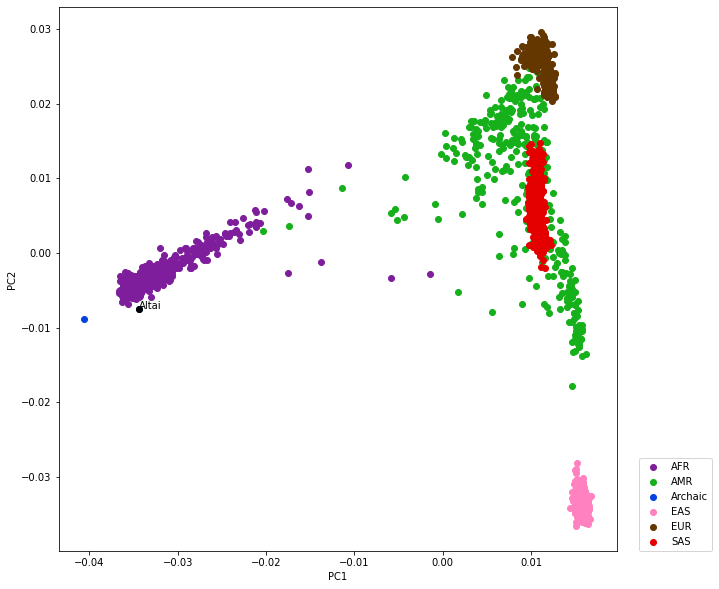

In [24]:
# Plot the top two PCs. Population labels = super_population
plot_pcs(pcs, 1, 2, pcs.super_population, [my_individual])
#setting my_individual as an archaic, can see how it clusters relative to humans

28


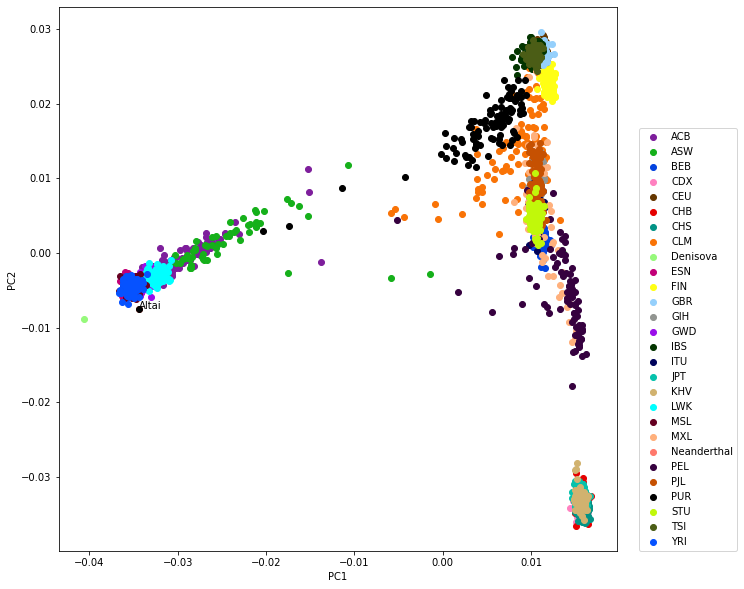

In [25]:
# Plot the top two PCs. Population labels = population
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

Display eigenvalues. https://github.com/DReichLab/EIG/tree/master/POPGEN

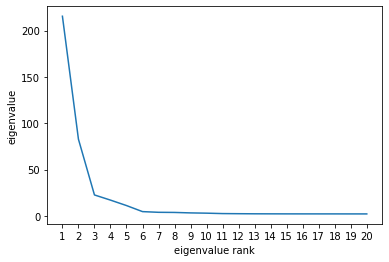

In [26]:
eigenvalues = np.loadtxt('1000G_archaic.eval')
plt.plot(np.arange(1, 21), eigenvalues[:20])
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue');
#remove these plots? Showed them last time

Display %variance explained

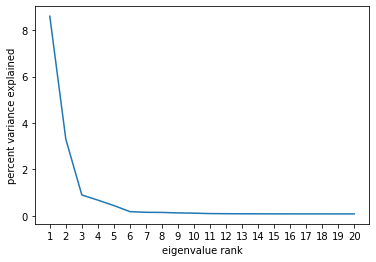

In [27]:
eigenvalues = np.loadtxt('1000G_archaic.eval')
plt.plot(np.arange(1, 21), 100 * eigenvalues[:20] / eigenvalues.sum())
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('percent variance explained');

# Admixture analysis

Alexander, David H., John Novembre, and Kenneth Lange. "Fast model-based estimation of ancestry in unrelated individuals." Genome research 19.9 (2009): 1655-1664.

https://genome.cshlp.org/content/19/9/1655.full

Software documentation: http://www.genetics.ucla.edu/software/admixture/admixture-manual.pdf

Usage: 

```!../../bin/admixture --cv 1000G_archaic.bed K```

where K = number of clusters

Running ADMIXTURE with K=2 clusters (runtime: ~4m)

In [ ]:
!../../bin/admixture --cv 1000G_archaic.bed 2

Each line in the output of ADMIXTURE contains the probability of an individual belonging to each cluster - not be to confused with ancestry proportion.

In [ ]:
admix = pd.read_csv('1000G_archaic.2.Q', ' ', header=None).values[order]
admix

Admixture plot where each color represents one cluster

In [ ]:
plot_admixture(admix, individuals.super_population.cat.codes, individuals.super_population.cat.categories);

Admixture plot with subcontinental ancestry

In [ ]:
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);
#showing same plots as before, except paying attention to how archaics cluster this time?
#what exactly are we trying to show with these plots 

In [ ]:
# Admixture output for Altai Neanderthal. 
plot_admix_individual(admix, 'Altai')

In [ ]:
# Admixture output for Denisova. 
plot_admix_individual(admix, 'Denisova')

Now let's run admixture with K=3 clusters

In [ ]:
!../../bin/admixture --cv 1000G_archaic.bed 3

Display output of ADMIXTURE (K=3)

In [ ]:
admix = pd.read_csv('1000G_archaic.3.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

In [ ]:
# Admixture output for the current individual (K=3)
plot_admix_individual(admix, my_individual)

For K=4,5,6 results have been precomputed, we can just load them. <br>Display output of ADMIXTURE (K=4)

In [ ]:
admix = pd.read_csv('1000G_archaic.4.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

In [ ]:
# Admixture output for the current individual (K=4)
plot_admix_individual(admix, 'Altai')

In [ ]:
plot_admix_individual(admix, 'Denisovan')

Display output of ADMIXTURE (K=5)

In [ ]:
admix = pd.read_csv('1000G_archaic.5.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

In [ ]:
# Admixture output for the current individual (K=5)
plot_admix_individual(admix, 'Altai')

In [ ]:
plot_admix_individual(admix, 'Denisovan')

Display output of ADMIXTURE (K=6)

In [ ]:
admix = pd.read_csv('1000G_archaic.6.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

In [ ]:
# Admixture output for the current individual (K=6)
plot_admix_individual(admix, 'Altai')

In [ ]:
plot_admix_individual(admix, 'Denisovan')

# Analysis of archaic introgression

Skov, Laurits, et al. "Detecting archaic introgression using an unadmixed outgroup." PLoS genetics 14.9 (2018): e1007641.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007641

Software: https://github.com/LauritsSkov/Introgression-detection

Usage:

`!python2 Introgression-detection/Train.py infile outprefix model weights_file mutfile`

`!python2 Introgression-detection/Decode.py infile outprefix model weights_file mutfile window_size`

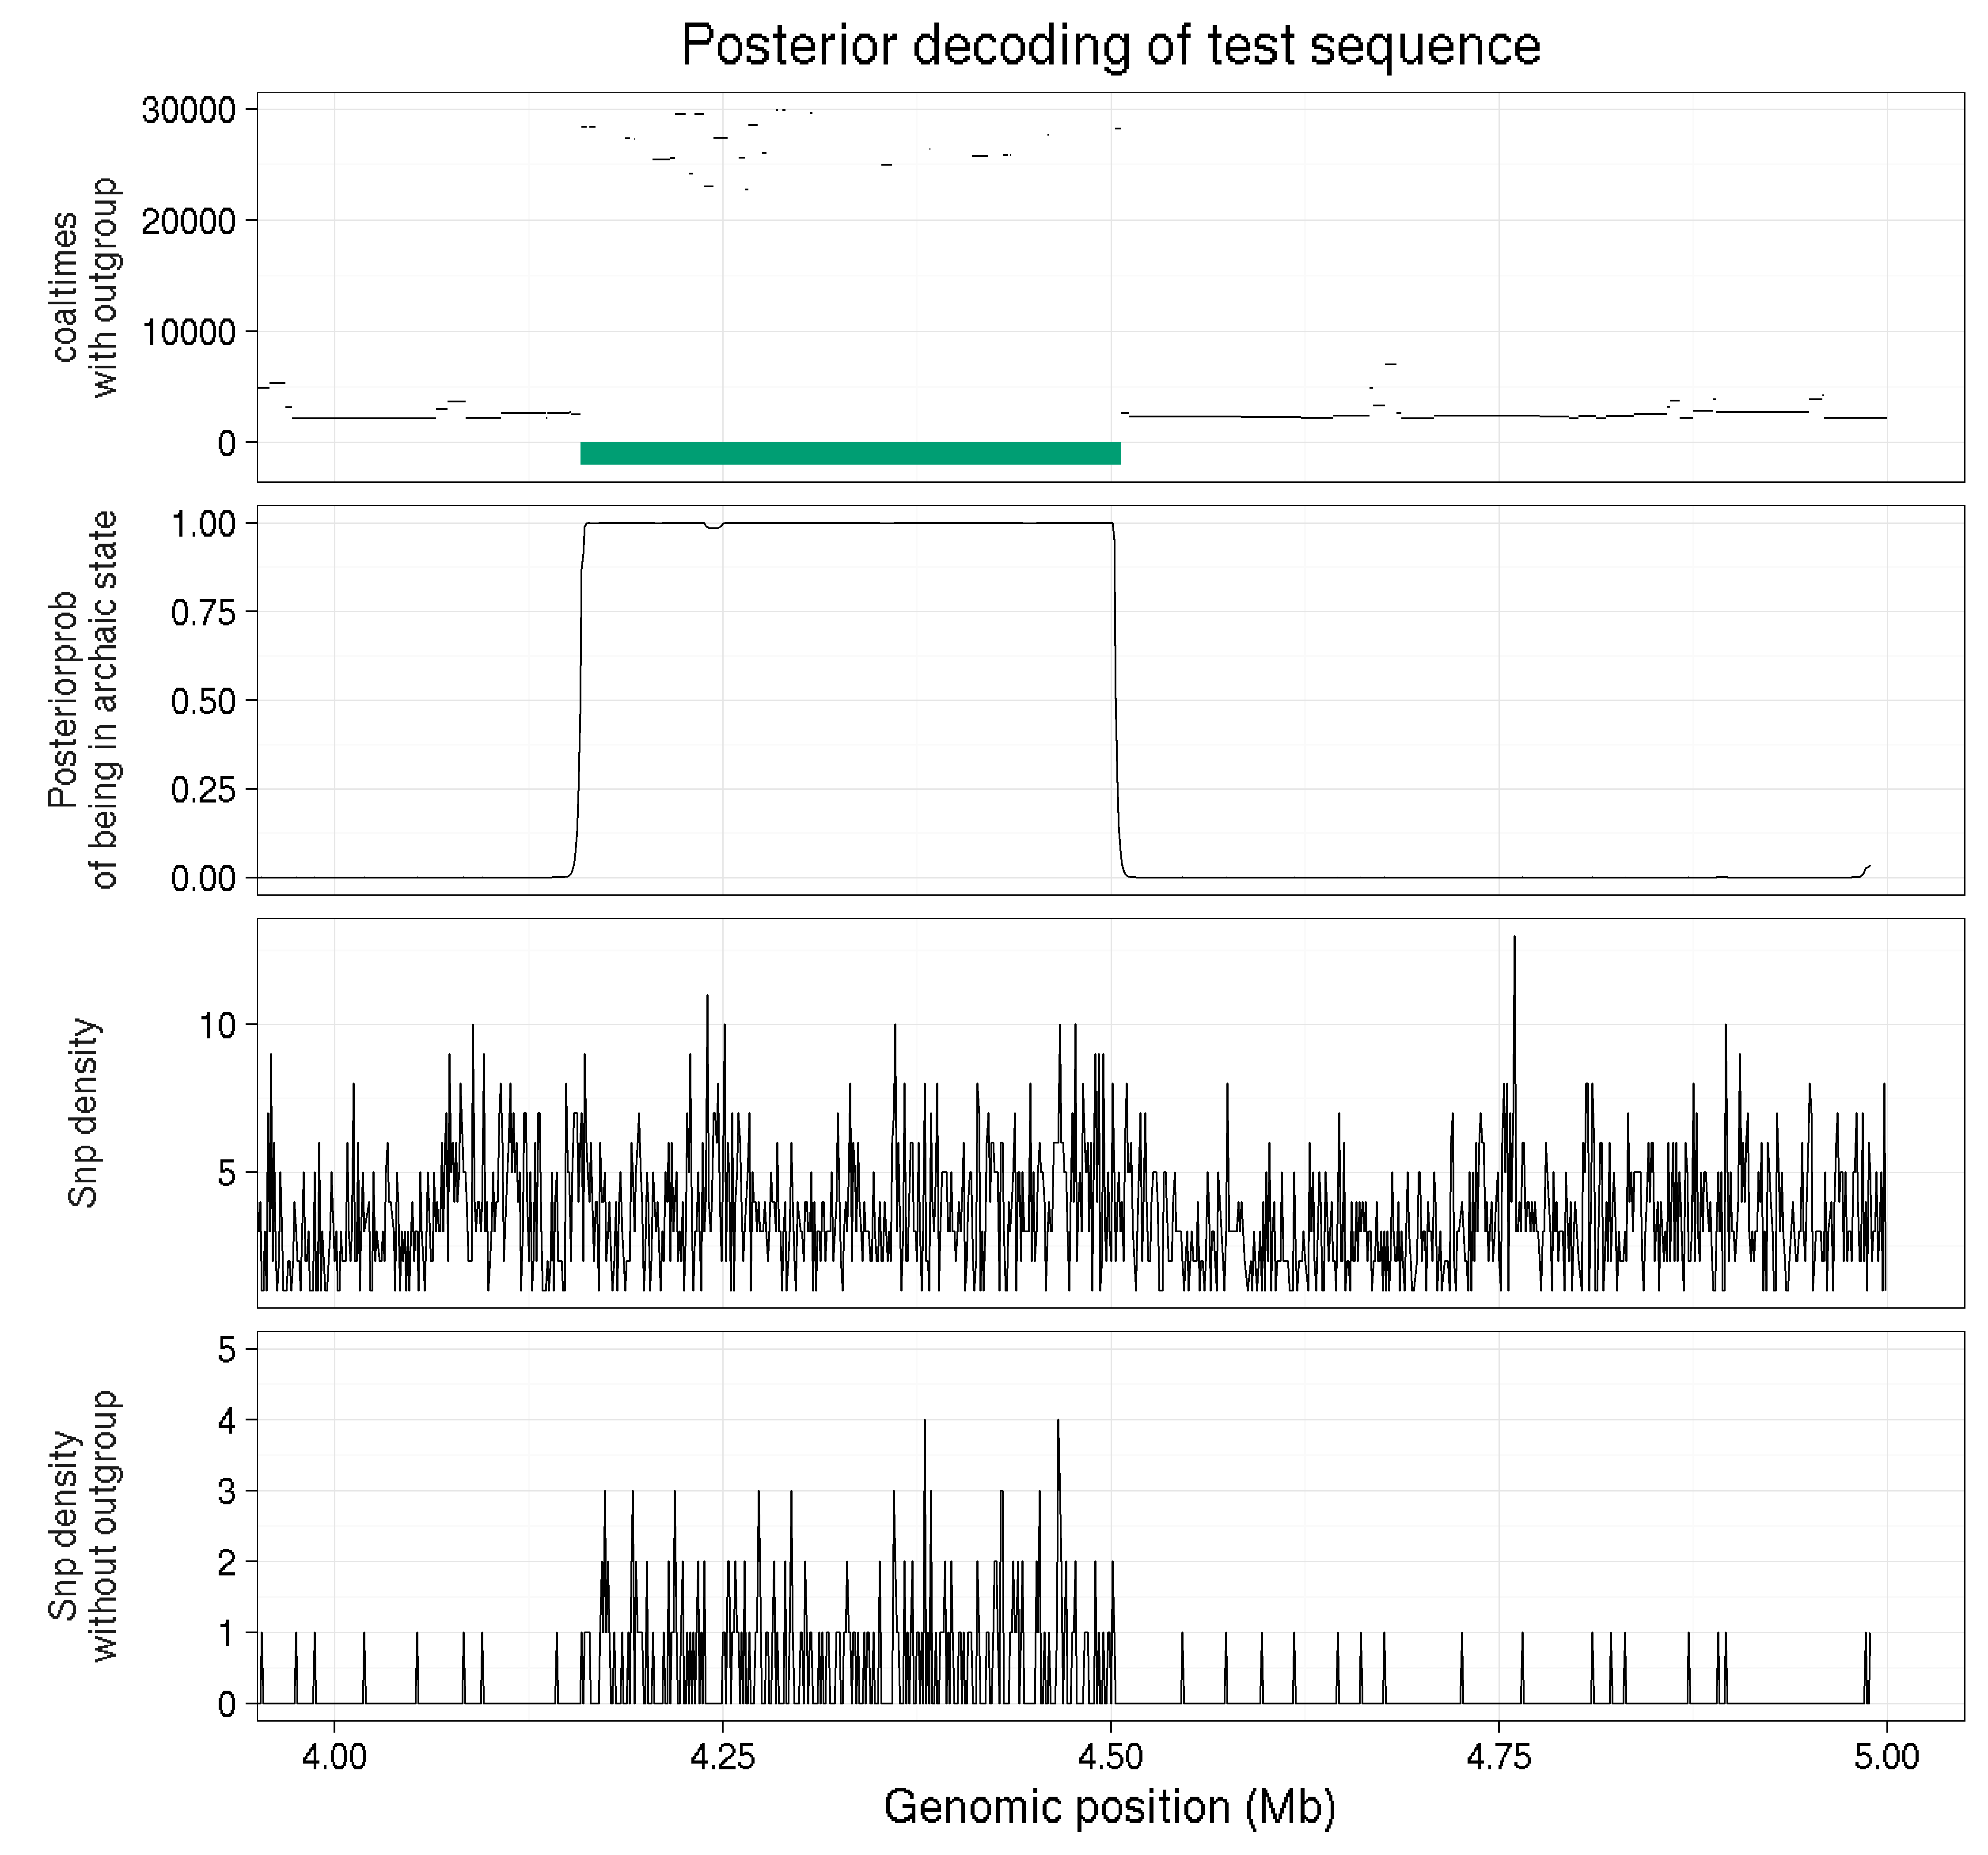

In [31]:
# Signal of archaic admixture
Image(filename='hmm-skov-3.png', height=500)

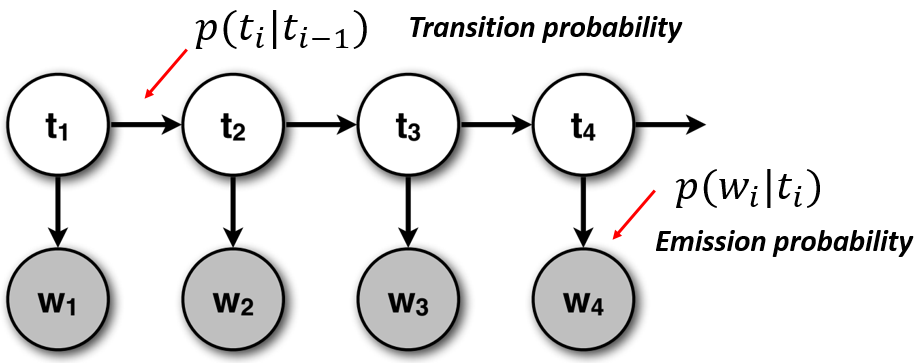

In [32]:
# What is an HMM
Image(filename='hmm.png', height=200) 

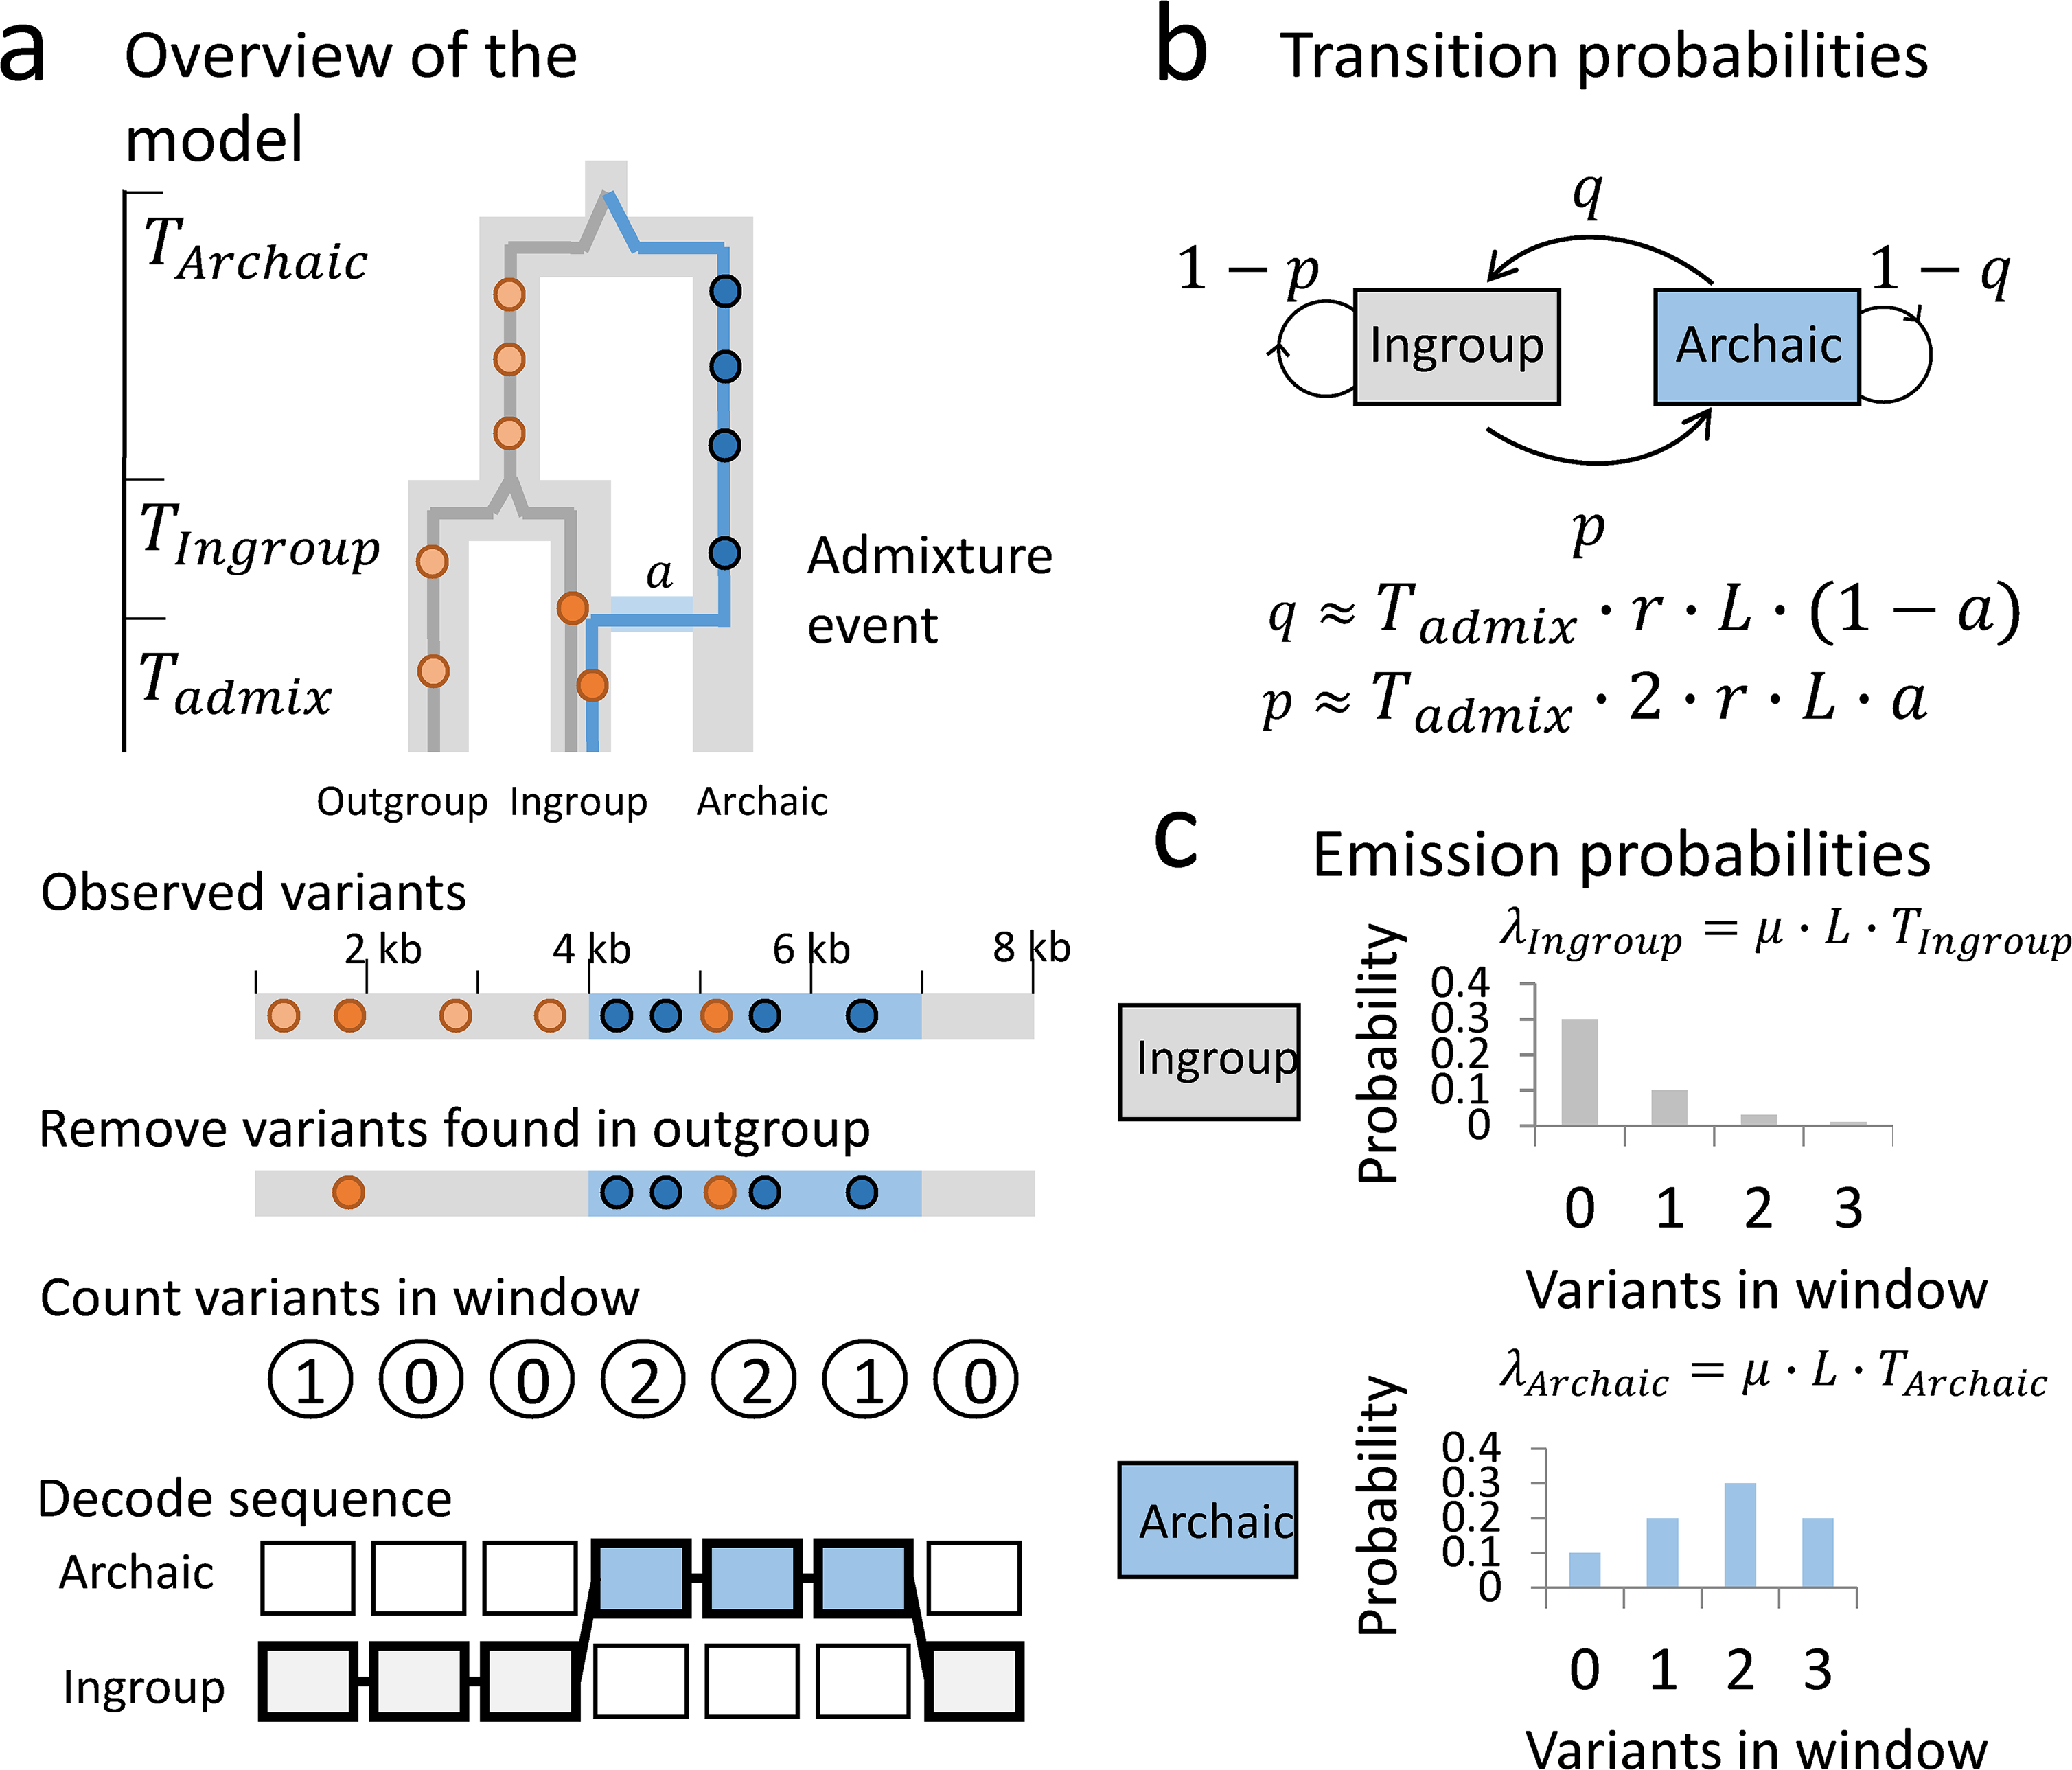

In [33]:
# Main idea for identifying segments of archaic ancestry
Image(filename='hmm-skov-2.png', height=500)

In [ ]:
# SKIP
#!python2 Introgression-detection/MakeMaskfiles.py chr17.fa.masked 20140520.chr17.strict_mask.fasta.gz 1000 17 chr17
#!cp chr17.txt weights.txt
#!cp chr17.bed weights.bed
#!cat integrated_call_samples_v3.20130502.ALL.panel | grep -E "YRI|ESN|MSL" | cut -f 1 > outgroups.txt
#!tabix -h ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz -R chr17.bed | vcftools --vcf - --counts --stdout --keep outgroups.txt --remove-indels --min-alleles 2 --max-alleles 2 > chr17.freq
#!python2 Introgression-detection/Estimate_mutationrate.py chr17.freq 1000000 1000 chr17.txt chr17.mut
#!cp chr17.mut mutationrates.txt
#!tabix -fh ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz -R chr17.bed | vcftools --vcf - --indv HG00096 --remove-indels --min-alleles 2 --max-alleles 2 --stdout --counts | python2 Introgression-detection/Filtervariants.py homo_sapiens_ancestor_17.fa chr17.freq 1000 chr17.txt HG00096.chr17.observations.txt

Configure files for the current individual

In [42]:
os.system(f"cp {my_individual}.chr17.observations.txt observations.txt");

### Define initial parameters for the HMM

In [41]:
%%writefile StartingParameters.hmm
# State names (only used for decoding)
states = ['Human','Archaic']

# Initialization parameters (prob of staring in states)
starting_probabilities = [0.98, 0.02]

# transition matrix
transitions = [[0.9995,0.0005],[0.012,0.98]]

# emission matrix (poisson parameter)
emissions = [0.04, 0.1]

Writing StartingParameters.hmm


### Train the HMM model

In [43]:
!python2 Introgression-detection/Train.py observations.txt trained StartingParameters.hmm weights.txt mutationrates.txt
#this throws an error if cloned right from Skov github
#Solution- include older version of this in class github folder

/content/CCB293-testing/data/1000G_archaic/CCB293-testing/data/1000G_archaic/Introgression-detection/templates.py:309: RuntimeWarning: divide by zero encountered in log
  top = np.logaddexp.reduce(forwards[state,:] + backwards[state,:] + np.log(observations))
/content/CCB293-testing/data/1000G_archaic/CCB293-testing/data/1000G_archaic/Introgression-detection/templates.py:310: RuntimeWarning: divide by zero encountered in log
  bottom = np.logaddexp.reduce(forwards[state,:] + backwards[state,:] + np.log(weights * mutrates) )
doing iteration 0 with old prob -11610.7920784 and new prob -10738.1554202
doing iteration 1 with old prob -10738.1554202 and new prob -10519.1650716
doing iteration 2 with old prob -10519.1650716 and new prob -10420.7471637
doing iteration 3 with old prob -10420.7471637 and new prob -10365.2380174
doing iteration 4 with old prob -10365.2380174 and new prob -10329.6595117
doing iteration 5 with old prob -10329.6595117 and new prob -10309.2946256
doing iteration 6 wi

In [44]:
# Display trained parameters
!cat trained.hmm

# State names (only used for decoding)
states = ['Human','Archaic']

# Initialization parameters (prob of staring in states)
starting_probabilities = [0.9914365597456, 0.008563440254358668]

# transition matrix
transitions = [[0.9998531139210742,0.0001468860789256895],[0.016999264798519157,0.9830007352014808]]

# emission matrix (poisson parameter)
emissions = [0.06773383135796911, 2.4097918107535183]


### Decode the most likely assignment of ancestry to windows

In [45]:
!python2 Introgression-detection/Decode.py observations.txt decoded trained.hmm weights.txt mutationrates.txt 1000

In [46]:
# Inference for every 1000Kb window
posterior_probs = pd.read_csv('decoded.All_posterior_probs.txt', '\t')
posterior_probs.head()

,chrom,start,observations,variants,Mostlikely,Human,Archaic
0,17,0,0,NaN,Human,0.999864,0.000136
1,17,1000,0,NaN,Human,0.999982,0.000018
2,17,2000,0,NaN,Human,0.999997,0.000003
3,17,3000,0,NaN,Human,0.999997,0.000003
4,17,4000,0,NaN,Human,0.999996,0.000004


In [47]:
posterior_probs[posterior_probs.observations>0].head()

,chrom,start,observations,variants,Mostlikely,Human,Archaic
42,17,42000,1,42756,Human,0.999829,0.000171
49,17,49000,1,49569,Human,0.999991,0.000009
73,17,73000,1,73654,Human,0.999725,0.000275
76,17,76000,1,76510,Human,0.999989,0.000011
82,17,82000,1,82381,Human,0.967746,0.032254


The most likeliy assignment of ancestry to the whole chromosome, split into contiguous segments of same ancestry

In [48]:
decoded_summary = pd.read_csv('decoded.Summary.txt', '\t')
decoded_summary.head()

,name,chrom,start,end,length,state,snps,mean_prob
0,decoded,17,0,12557000,12557000,Human,438,0.999458
1,decoded,17,12557000,12566000,9000,Archaic,6,0.853354
2,decoded,17,12566000,12618000,52000,Human,8,0.986419
3,decoded,17,12618000,12649000,31000,Archaic,22,0.943389
4,decoded,17,12649000,43724000,31075000,Human,752,0.998450


Obtain the windows ancestry assignment

In [49]:
window_assignment = (posterior_probs.Mostlikely=='Archaic')

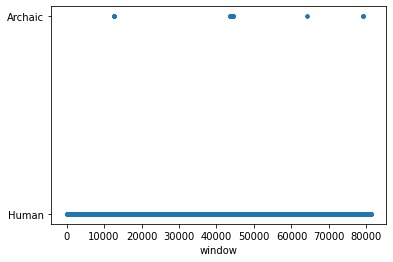

In [50]:
# Plot the assignment of the whole chromosome
plot_window_assignment(window_assignment)

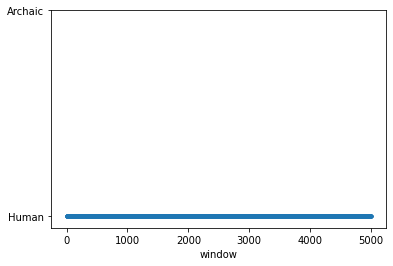

In [51]:
# Plot assignment of the first 5000 windows
plot_window_assignment(window_assignment[:5000])

In [52]:
# Obtain number of observations per window of Human or Archaic ancestry
obs_human = posterior_probs.observations[posterior_probs.Mostlikely=='Human']
obs_archaic = posterior_probs.observations[posterior_probs.Mostlikely=='Archaic']
max_human = obs_human.max()
max_archaic = obs_archaic.max()

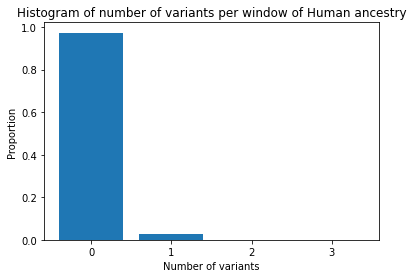

In [53]:
# Plot the number of variants per window of human ancestry
plt.bar(np.arange(max_human+1), [(obs_human==i).mean() for i in range(max_human+1)]);
plt.xticks(np.arange(max_human+1));
plt.xlabel('Number of variants')
plt.ylabel('Proportion')
plt.title('Histogram of number of variants per window of Human ancestry');

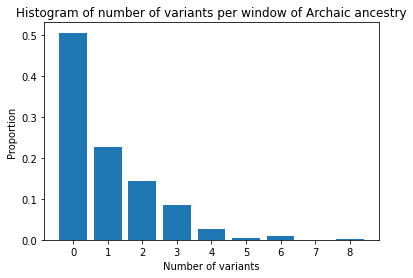

In [54]:
# Plot the number of variants per window of archaic ancestry
plt.bar(np.arange(max_archaic+1), [(obs_archaic==i).mean() for i in range(max_archaic+1)]);
plt.xticks(np.arange(max_archaic+1));
plt.xlabel('Number of variants')
plt.ylabel('Proportion')
plt.title('Histogram of number of variants per window of Archaic ancestry');